# Data preparation 

Let's first only classify 30 dog breed from Standford dataset. 
Which are the one with the most images provided (number of images superior to the third inter-quartile)

https://www.youtube.com/watch?v=7Mv91hcxCCI&t=137s

In [29]:
%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import cv2 
# importing shutil module 
import shutil 
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input
from common_params import data_dir, img_dir, npy_dir, MAX_NUMBER_CLASS
from common_plots import display_images
from common_data_functions import delete_files_in_directory, copy_files_from_dir, prepare_subfolder_extract

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print(tf.__version__)

2.11.0


### Load images 

Let's begin with imbalanced dataset
I choose to use image_dataset_from_directory instead of ImageDataGenerator  because of the speed benchmark [here](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

In [41]:
IMG_SIZE = 224
batch_size = 32

input_shape = (224, 224, 3) 

##  DATASET SUBSET

In [34]:
NB_IMG_PER_CLASS = 10 
NB_CLASS = 2
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)

# Add : only take NB_CLASS classes

In [43]:
imgsub_dir = prepare_subfolder_extract(NB_IMG_PER_CLASS, NB_CLASS, list_of_folder) 

C:/dev/image_classification/data/extracted\n02085936-Maltese_dog C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\n02085936-Maltese_dog\n02085936_10073_0.jpg
C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog\n02085936_10073_0.jpg
C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog\n02085936_10073_0.jpg
C:/dev/image_classification/data/extracted\n02085936-Maltese_dog\n02085936_10130_0.jpg
C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog\n02085936_10130_0.jpg
C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog\n02085936_10130_0.jpg
C:/dev/image_classification/data/extracted\n02085936-Maltese_dog\n02085936_10148_0.jpg
C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog\n02085936_10148_0.jpg
C:/dev/image_classification/data/images_subset\n02085936-Maltese_dog\n02085936_10148_0.jpg
C:/dev/image_classification/data/extracted\n02085936-Maltes

In [42]:
train_ds, validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    imgsub_dir,
    seed=59,
    # labels= "inferred",
    subset="both",
    # label_mode='categorical',
    validation_split=0.2,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size
    )


Found 20 files belonging to 2 classes.
Using 16 files for training.
Using 4 files for validation.


In [267]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes

30

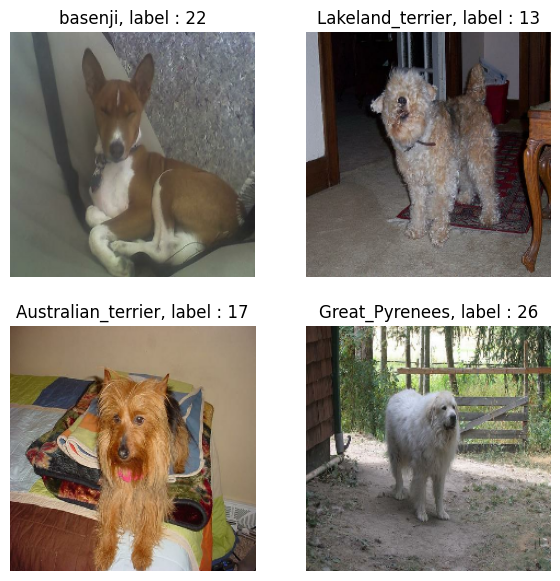

In [157]:
plt.figure(figsize=(7, 7))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]].split('-')[1]}, label : {labels[i]}")
        plt.axis("off")

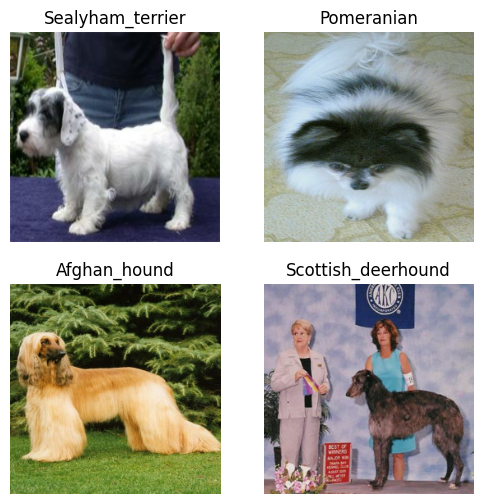

In [53]:
plt.figure(figsize=(6, 6))
class_names = validation_ds.class_names
for images, labels in validation_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]].split('-')[1])
        plt.axis("off")

# Data augmentation 

In [54]:
data_augmentation = tf.keras.Sequential(
    [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1)
            
    ]
)

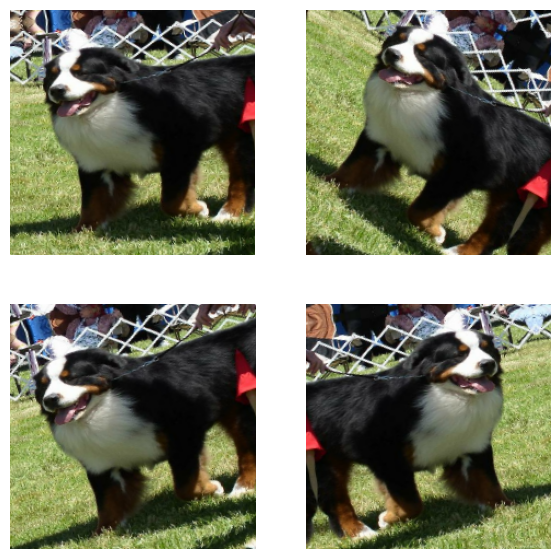

In [112]:

plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [209]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU available : {len(physical_devices)}")

Number of GPU available : 0


# Standardize

In [268]:
if len(physical_devices) == 0 : 
    augmented_train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y))
else : 
    # Apply `data_augmentation` to the training images.
    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    # Prefetching samples in GPU memory helps maximize GPU utilization.
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)
    
# One -Hot on labels 
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
validation_ds = validation_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

[75.52754  50.696842 28.945633]
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(30,), dtype=float32)
8
n02091134-whippet


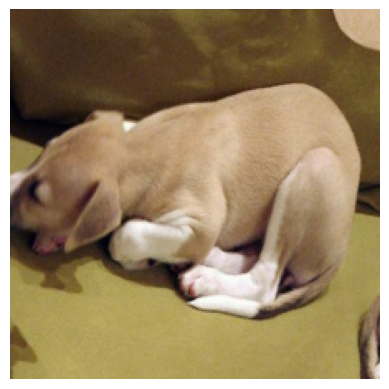

In [318]:
for img, labels in train_ds.take(1) :
    img_array = keras.utils.img_to_array(img[0])
    plt.imshow(img_array.astype("uint8"))
    plt.axis("off")
    print(img_array[0][0])
    print(labels[0])
    label_arg = np.argmax(labels[0])
    print(label_arg)
    print(class_names[label_arg])


[65.69196  51.691963 50.691963]
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(30,), dtype=float32)
14
n02095889-Sealyham_terrier


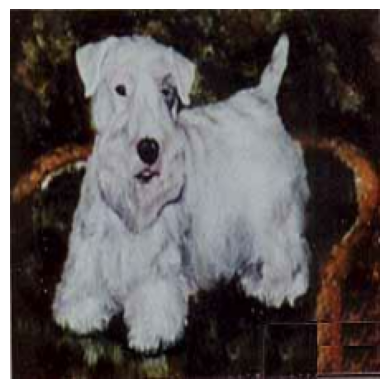

In [317]:



for img, labels in validation_ds.take(1) :
    img_array = keras.utils.img_to_array(img[0])
    plt.imshow(img_array.astype("uint8"))
    plt.axis("off")
    print(img_array[0][0])
    print(labels[0])
    label_arg = np.argmax(labels[0])
    print(label_arg)
    print(class_names[label_arg])

# My convolutional neural network 

In [326]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling

def get_personal_model():
    model = Sequential()
    model.add(Rescaling( 1.0 / 255 , input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu')) # kernel = 3*3
    model.add(MaxPooling2D((2, 2),strides=(2,2),padding="same"))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='softmax'))

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model 

In [327]:
cnn_based_model = get_personal_model()

In [328]:
cnn_based_model.build(input_shape)

In [329]:
keras.utils.plot_model(cnn_based_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [330]:
cnn_based_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 52, 256)      

In [331]:
experiment_name = "cnn-dog-breed-classifier"
run_name = datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join(data_dir,"logs", experiment_name, run_name)
tb_callback = [tf.keras.callbacks.TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)]


In [313]:
os.path.isdir(logdir)

True

In [334]:


history = cnn_based_model.fit(
    train_ds,
    epochs=10,
    callbacks=tb_callback,
    validation_data=validation_ds)

Epoch 1/10
155/155 [==============================] - 795s 5s/step - loss: 0.1809 - accuracy: 0.0349 - val_loss: 0.1467 - val_accuracy: 0.0414
Epoch 2/10
155/155 [==============================] - 1534s 5s/step - loss: 0.1735 - accuracy: 0.0349 - val_loss: 0.1463 - val_accuracy: 0.0373
Epoch 3/10
155/155 [==============================] - 791s 5s/step - loss: 0.1702 - accuracy: 0.0341 - val_loss: 0.1479 - val_accuracy: 0.0528
Epoch 4/10
155/155 [==============================] - 1298s 8s/step - loss: 0.1675 - accuracy: 0.0363 - val_loss: 0.1464 - val_accuracy: 0.0601
Epoch 5/10
155/155 [==============================] - 3186s 21s/step - loss: 0.1641 - accuracy: 0.0365 - val_loss: 0.1465 - val_accuracy: 0.0568
Epoch 6/10
155/155 [==============================] - 557s 4s/step - loss: 0.1634 - accuracy: 0.0320 - val_loss: 0.1461 - val_accuracy: 0.0560
Epoch 7/10
155/155 [==============================] - 552s 4s/step - loss: 0.1621 - accuracy: 0.0406 - val_loss: 0.1455 - val_accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


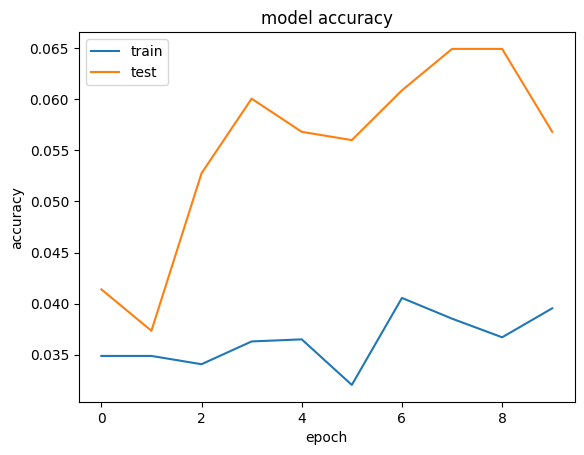

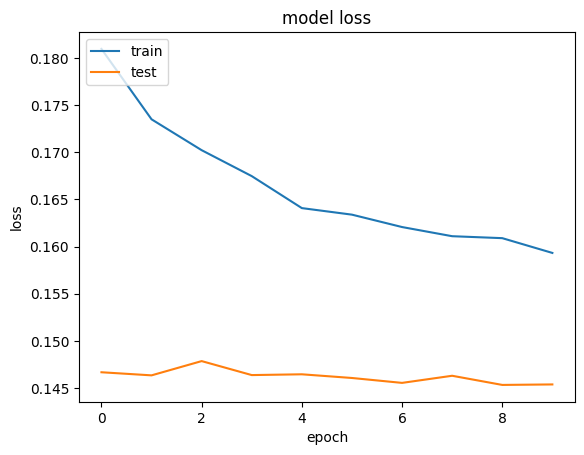

In [335]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [249]:
img = keras.utils.load_img(
    os.path.join(img_dir,"n02085620-Chihuahua\\n02085620_7.jpg"), target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = cnn_based_model.predict(img_array)
print(predictions)


1/1 [==============================] - 0s 215ms/step
[[0.03336657 0.03330528 0.03331576 0.03332538 0.03333196 0.03331489
  0.03330834 0.03335355 0.03337905 0.0333891  0.03329747 0.03330733
  0.03329911 0.03336873 0.03330065 0.03335722 0.0333079  0.03332188
  0.0333128  0.03337359 0.033304   0.0333653  0.03336687 0.0333185
  0.0333299  0.0333218  0.03339823 0.03334411 0.03330163 0.03331314]]


In [251]:
score = np.argmax(predictions)
score

26

In [255]:
print(f"This image is more likely to be a {class_names[score].split('-')[1]}")

This image is more likely to be a Great_Pyrenees
